# Evaluate the Performance and Accuracy as a Function of Runtime
Longer MD simulations are good because they produce more accurate estimates of stability and are less affected by the inefficiencies of task startup.
However, they take longer.
We explore the tradeoff between these effects in this notebook.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

Configuration

In [2]:
target_system = 'polaris'
lammps_exe = '/lus/eagle/projects/ExaMol/mofa/lammps-2Aug2023/build-kokkos-nompi/lmp'

## Load Runtime Results
We saved the results of tests with different MOFs and different system configurations in `runtime.json`

In [3]:
runtimes = pd.read_json('runtimes.json', lines=True)
print(f'Loaded {len(runtimes)} experiments')

Loaded 574 experiments


Get only the target system and LAMMPS executable

In [4]:
runtimes = runtimes[runtimes.host.str.startswith(target_system)]
runtimes = runtimes[runtimes.lammps_cmd.apply(lambda x: x[0] == lammps_exe)]
print(f'Downselected to {len(runtimes)} experiments')

Downselected to 207 experiments


## Plot Timestep Rate vs Timestep Count
We should see faster simulations at larger timesteps

In [5]:
runtimes['rate'] = runtimes['timesteps'] / runtimes['runtime']

In [6]:
avg_by_length = runtimes.groupby('timesteps')[['runtime', 'rate']].mean()

Text(0, 0.5, 'Rate (steps/s)')

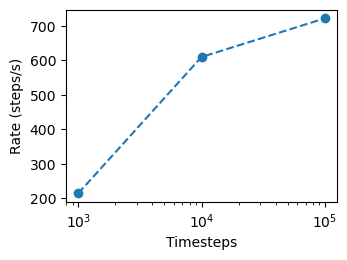

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogx(avg_by_length.index, avg_by_length['rate'], '--o')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Rate (steps/s)')

## Plot Strain Over Timesteps
See how much the measurements of strain change over time. Get the relative difference between the strain and that computed with the maximum timestep count for each MOF

In [8]:
def error_from_best_estimate(group):
    best_est = group[group.timesteps == group['timesteps'].max()]['strain'].mean()
    return (1 - group['strain'] / best_est) * 100

In [9]:
runtimes['error'] = runtimes.groupby('mof', group_keys=False).apply(error_from_best_estimate)

In [10]:
avg_by_length = runtimes.groupby('timesteps')[['error']].agg(['mean', 'std'])

Text(0, 0.5, 'Error, Relative (%)')

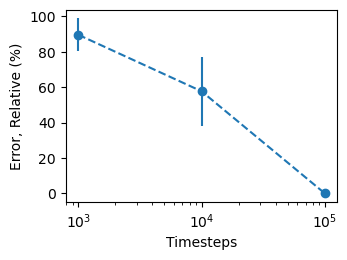

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.errorbar(avg_by_length.index, avg_by_length['error']['mean'], fmt='--o', yerr=avg_by_length['error']['std'])
ax.set_xscale('log')


ax.set_xlabel('Timesteps')
ax.set_ylabel('Error, Relative (%)')